In [4]:
import pandas as pd
import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import os
import shutil
import random
import numpy as np
from tqdm.notebook import tqdm

from pydub import AudioSegment
from pydub.silence import detect_leading_silence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objs as go
import plotly
from scipy.io import wavfile
import noisereduce as nr
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import sys
from tqdm import tqdm


In [5]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
samplesubmission = pd.read_csv('SampleSubmission.csv')


In [60]:
samplesubmission

Word_id  hapana  kumi  mbili  moja  nane  ndio  nne  saba  \
0     id_jp2pxl0r84ya.wav       0     0      0     0     0     0    0     0   
1     id_ndduqqvthbpx.wav       0     0      0     0     0     0    0     0   
2     id_36oxymxfcm6q.wav       0     0      0     0     0     0    0     0   
3     id_ue9b0to760pg.wav       0     0      0     0     0     0    0     0   
4     id_prja4oprb914.wav       0     0      0     0     0     0    0     0   
...                   ...     ...   ...    ...   ...   ...   ...  ...   ...   
1795  id_fbjz7hzobv82.wav       0     0      0     0     0     0    0     0   
1796  id_2zbyc2c8isg6.wav       0     0      0     0     0     0    0     0   
1797  id_hbjytnn77s2e.wav       0     0      0     0     0     0    0     0   
1798  id_ikrso2p0f7xf.wav       0     0      0     0     0     0    0     0   
1799  id_ii8obtx41kn8.wav       0     0      0     0     0     0    0     0   

      sita  tano  tatu  tisa  
0        0     0     0     0  
1        0     0     0     0  
2        0     0     0     0  
3        0     0     0     0  
4        0     0     0     0  
...    ...   ...   ...   ...  
1795     0     0     0     0  
1796     0     0     0     0  
1797     0     0     0     0  
1798     0     0     0     0  
1799     0     0     0     0  

[1800 rows x 13 columns]

In [7]:
# number of classes
train['Swahili_word'].nunique()

12

# Preprocessing stages:
- remove silent segments, leave audio events
- reduce background noise
- augmentation?
- extract features
- create spectrograms
- decide on modelling approach: CNN for spectrogram analysis + DNN for features analysis 

## Examine a single sample of the data

In [8]:
# read WAV file using scipy.io.wavfile
fs, data = wavfile.read("Swahili_words/id_v8rz06e6rv31.wav")

In [9]:
display("mbili", "id_01dntd19l4a8.wav", ipd.Audio("Swahili_words/id_v8rz06e6rv31.wav"))

'mbili'

'id_01dntd19l4a8.wav'

In [10]:
print('Signal Duration = {} seconds'.format(data.shape[0] / fs))

Signal Duration = 3.584 seconds


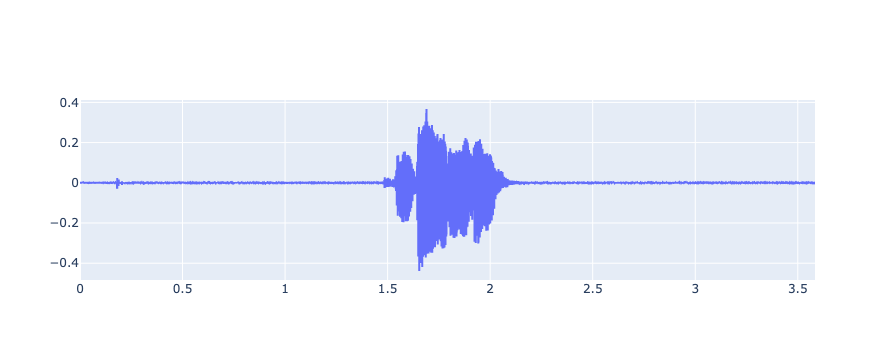

In [11]:
# normalize data for perfoming further computations
data_norm = data / (2**15)
time = np.arange(0, len(data)) / fs
plotly.offline.iplot({ "data": [go.Scatter(x=time, 
                                           y=data_norm, 
                                           name='normalized audio signal')]})

## Clean and preprocess data

In [224]:
def normalize_data(data):
    return data / (2**15)


def remove_silence(data_norm, fs):
    # break a signal into a fix-sized segments
    data_len = len(data_norm)
    segment_size_t = 1 # segment size in seconds
    segment_size = segment_size_t * fs  # segment size in samples
    # Break signal into list of segments in a single-line Python code
    segments = np.array([data_norm[x:x + segment_size] for x in
                         np.arange(0, data_len, segment_size)])
    # Remove pauses using an energy threshold = 50% of the median energy:
    energies = [(s**2).sum() / len(s) for s in segments]
    # (attention: integer overflow would occure without normalization here!)
    thres = 0.5 * np.median(energies)
    index_of_segments_to_keep = (np.where(energies > thres)[0])
    # get segments that have energies higher than a the threshold:
    segments2 = segments[index_of_segments_to_keep]
    # concatenate segments to signal:
    clean_data = np.concatenate(segments2)
    return clean_data

def reduce_noise(data, fs):
    return np.array(nr.reduce_noise(y=data, sr=fs), dtype='float')

def extract_features(data, fs):
    features, names=ShortTermFeatures.feature_extraction(data, fs, 0.050*fs, 0.050*fs)
    return features

# Going from a sound to an image: spectrograms
#os.mkdir('spectrograms_v2') # Create a folder to store the spectrograms

# Function to generate spectrogram
def gen_spectrogram(path):
    x , sr = librosa.load(path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X)[:,:min(1025, len(X[0]))])
    fig = plt.figure(frameon=False)
    fig.set_size_inches(15, 15)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(Xdb, aspect='auto')
    spec_path = 'spectrograms_v2/' + file_name[:-4] +'.png'
    fig.savefig(spec_path, dpi=512//8)
    plt.close()

    


In [225]:
train_dict = {}
lengths = []
for file_name in tqdm(train["Word_id"]):
    data_path = os.path.join("Swahili_words", file_name)
    fs, data = wavfile.read(data_path)
    #data_reduce_noise = reduce_noise(data, fs)
    #data_no_silence = remove_silence(data_reduce_noise, fs)
    # create spectrogram of cleaned data
    spec_path = 'spectrograms_v2/' + file_name[:-4] +'.png'
    if not os.path.isfile(spec_path):
        plt.clf()
        #gen_spectrogram(data_no_silence, fs, file_name)
        gen_spectrogram(data_path)
#     data_norm = normalize_data(data_no_silence)

#     lengths.append(data_norm.shape[0])
#     # trim all signals to 3 seconds
#     if data_norm.shape[0]>fs*3:
#         data_norm = data_norm[:fs*3]
#     if data_norm.shape[0]<fs*3:
#         data_norm = np.pad(data_norm, (0, fs*3 - len(data_norm)), 'constant')
    
#     features=extract_features(data_norm, fs)
#     train_dict[file_name] = features
    

100%|███████████████████████████████████████| 4200/4200 [14:07<00:00,  4.96it/s]


<Figure size 640x480 with 0 Axes>

In [80]:
def preprocess_data(df):
    features_dict = {}
    lengths = []
    for file_name in tqdm(df["Word_id"]):
        # data_path = os.path.join("Swahili_words", file_name)
        # fs, data = wavfile.read(data_path)
        # data_reduce_noise = reduce_noise(data, fs)
        # data_no_silence = remove_silence(data_reduce_noise, fs)
        # create spectrogram of cleaned data
        spec_path = 'spectrograms_v2/' + file_name[:-4] +'.png'
        if not os.path.isfile(spec_path):
            plt.clf()
            gen_spectrogram(data_path)    
        #data_norm = normalize_data(data_no_silence)

#         lengths.append(data_norm.shape[0])
#         # trim all signals to 3 seconds
#         if data_norm.shape[0]>fs*3:
#             data_norm = data_norm[:fs*3]
#         if data_norm.shape[0]<fs*3:
#             data_norm = np.pad(data_norm, (0, fs*3 - len(data_norm)), 'constant')

#         features=extract_features(data_norm, fs)
#         features_dict[file_name] = features
        


In [14]:
train['id']=train['Word_id'].apply(lambda x: x.split('.')[0])
train

Word_id Swahili_word English_translation               id
0     id_v8rz06e6rv31.wav        mbili                 two  id_v8rz06e6rv31
1     id_vmbwicdpfn68.wav         tatu               three  id_vmbwicdpfn68
2     id_injlouhxg1hg.wav         ndio                 yes  id_injlouhxg1hg
3     id_gdq23p6xgzya.wav          nne                four  id_gdq23p6xgzya
4     id_lpstklz51zpz.wav         nane               eight  id_lpstklz51zpz
...                   ...          ...                 ...              ...
4195  id_ho8aqa3s42zp.wav       hapana                  no  id_ho8aqa3s42zp
4196  id_3lhkgf9dqr4c.wav         kumi                 ten  id_3lhkgf9dqr4c
4197  id_ixb7vv4i0zct.wav         tano                five  id_ixb7vv4i0zct
4198  id_7tboov3kavg4.wav          nne                four  id_7tboov3kavg4
4199  id_de7l1v9qibbc.wav         kumi                 ten  id_de7l1v9qibbc

[4200 rows x 4 columns]

In [226]:
# organize spectrograms into folders to create tf.kerasDataset object
data_path = 'spectrograms_v2'
train_data_folder='train_data'
data_classes = train['Swahili_word'].unique()

In [227]:
# create train directory with proper structure
if not os.path.isdir(train_data_folder):
    os.mkdir(train_data_folder)
    for data_class in data_classes:
        class_folder=os.path.join(train_data_folder, data_class)
        if not os.path.isdir(class_folder):
            os.mkdir(class_folder)
        
# copy spectrograms
for file_name in os.listdir('spectrograms_v2'):
    # filtering only files not directories
    if os.path.isfile(os.path.join(data_path, file_name)):
        audio_id = file_name[:-4]
        sys.stdout.write('\r' + 'processing %s'%file_name)
        try:
            file_class = train[train['id']==audio_id]['Swahili_word'].values[0]
            shutil.copy2(os.path.join(data_path, file_name), os.path.join(train_data_folder, file_class, file_name))
        except IsADirectoryError:
            pass
        sys.stdout.flush()


processing id_1maaphk2zo6r.png

In [20]:
from PIL import Image

filepath = "train_data/nane/id_09yb6k6xebk5.png"
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height
  
# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)


The height of the image is:  960
The width of the image is:  960


In [228]:
# create Dataset object that could be accepted by Keras
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 16
img_height = img.height
img_width = img.width

X_train = image_dataset_from_directory(train_data_folder,
                                      validation_split=0.2,
                                      subset='training',
                                      seed=123,
                                       #label_mode='categorical',
                                      batch_size=batch_size, 
                                      image_size=(img_height, img_width))

X_val = image_dataset_from_directory(train_data_folder,
                                    validation_split=0.2,
                                    subset='validation',
                                    seed=123, 
                                     #label_mode='categorical',
                                     batch_size=batch_size,
                                     image_size=(img_height, img_width)
                                    )

Found 4200 files belonging to 12 classes.
Using 3360 files for training.
Found 4200 files belonging to 12 classes.
Using 840 files for validation.


In [229]:
class_names = X_train.class_names

In [230]:
# double check the data
for image_batch, labels_batch in X_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 960, 960, 3)
(16,)


In [53]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 6,  1,  3,  3,  4,  8,  0,  7, 11,  0, 10,  4, 10,  6,  2, 10,  9,
        2,  1,  8,  7,  7,  5, 11,  7, 10,  2,  6,  8,  8, 11,  9],
      dtype=int32)>

In [231]:
AUTOTUNE = tf.data.AUTOTUNE

X_train = X_train.prefetch(buffer_size=AUTOTUNE)
X_val=X_val.prefetch(buffer_size=AUTOTUNE)


In [232]:
num_classes = len(data_classes)

model = keras.Sequential([
    layers.Resizing(256, 256, input_shape=(img_height, img_width, 3),
                    interpolation='bilinear', crop_to_aspect_ratio=True),
    layers.Rescaling(1./255),
    layers.Conv2D(8, 7, padding='same', activation='elu', kernel_regularizer=keras.regularizers.l1(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 5, padding='same', activation='elu', kernel_regularizer=keras.regularizers.l1(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, padding='same', activation='elu', kernel_regularizer=keras.regularizers.l1(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='elu', kernel_regularizer=keras.regularizers.l1(0.001)),
    layers.Dense(num_classes, activation='softmax')
])

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_20 (Resizing)      (None, 256, 256, 3)       0         
                                                                 
 rescaling_20 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 256, 256, 8)       1184      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 16)      3216      
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                

In [242]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00005),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [234]:
# use TensorBoard for monitoring
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    import time
    run_id=time.strftime('run_%Y_%m_%d-%H-%M-%S')
    return os.path.join(root_logdir, run_id)
    
run_logdir=get_run_logdir()

In [235]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint('best_CNN_v2.h5', save_best_only=True)

In [244]:
epochs=15
history = model.fit(
  X_train,
  validation_data=X_val,
  epochs=epochs,
callbacks=[tensorboard_cb, checkpoint_cb])

Epoch 1/15
210/210 [==============================] - 40s 189ms/step - loss: 1.5215 - accuracy: 0.6905 - val_loss: 1.8105 - val_accuracy: 0.6214
Epoch 2/15
210/210 [==============================] - 42s 195ms/step - loss: 1.4897 - accuracy: 0.7015 - val_loss: 1.8245 - val_accuracy: 0.6024
Epoch 3/15
210/210 [==============================] - 42s 198ms/step - loss: 1.4759 - accuracy: 0.7048 - val_loss: 1.8015 - val_accuracy: 0.6226
Epoch 4/15
210/210 [==============================] - 43s 200ms/step - loss: 1.4492 - accuracy: 0.7122 - val_loss: 1.7903 - val_accuracy: 0.6131
Epoch 5/15
210/210 [==============================] - 43s 201ms/step - loss: 1.4398 - accuracy: 0.7161 - val_loss: 1.7727 - val_accuracy: 0.6405
Epoch 6/15
210/210 [==============================] - 43s 201ms/step - loss: 1.4241 - accuracy: 0.7226 - val_loss: 1.8007 - val_accuracy: 0.6143
Epoch 7/15
210/210 [==============================] - 45s 209ms/step - loss: 1.3898 - accuracy: 0.7330 - val_loss: 1.7588 - val_ac

# Predict new data and submit

In [252]:
preprocess_data(test)

  0%|                                                  | 0/1800 [00:00<?, ?it/s]/var/folders/13/mypf120d6gz5n4nv6xpbp1sm0000gn/T/ipykernel_5524/1539500982.py:11: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

100%|███████████████████████████████████████| 1800/1800 [02:09<00:00, 13.95it/s]


In [253]:
model = keras.models.load_model("best_CNN_v2.h5")

In [246]:
test_inst = test['Word_id'].values[0]
test_inst2=test_inst[:-4]+'.png'
img = keras.utils.load_img(os.path.join('spectrograms_v2', test_inst2))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
predictions

2022-09-11 17:14:12.529314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[2.3643108e-05, 1.0649205e-04, 3.9194533e-04, 3.7225578e-03,
        5.6766055e-04, 1.6306981e-02, 9.0537959e-04, 1.6952910e-02,
        6.3010693e-02, 1.7707187e-05, 4.5821816e-03, 8.9341182e-01]],
      dtype=float32)

In [254]:
predictions_dict={}

for test_inst in tqdm(test['Word_id'].values):
    test_inst2=test_inst[:-4]+'.png'
    img = tf.keras.utils.load_img(os.path.join('spectrograms_v2', test_inst2))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    #score = tf.nn.softmax(predictions[0])
    predictions_dict[test_inst] = np.array(predictions)[0]


  0%|                                                  | 0/1800 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'spectrograms_v2/id_jp2pxl0r84ya.png'

In [248]:
submission = pd.DataFrame.from_dict(predictions_dict, columns=class_names, orient='index')


In [249]:
submission.to_csv('submission.csv')

In [113]:
X_train = np.array(list(train_dict.values()))
train_ids =np.array(list(train_dict.keys()))

In [114]:
X_train.shape

(4200, 68, 60)

In [115]:
y_train=pd.DataFrame(train_ids, columns=['id']).merge(train,
                                                    how='left', 
                                                    left_on='id',
                                                    right_on='Word_id')['Swahili_word'].values.tolist()

In [116]:
le=LabelEncoder()
y_train = le.fit_transform(y_train)

In [107]:
y_train = np.array(y_train).reshape(-1, 1)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train)

In [117]:
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, random_state=42)

# Modelling

1. Debug existing model 
2. Create CNN that analyzes spectrogram and add CNN features as additional input to the existing model

In [118]:
model = keras.Sequential()
model.add(layers.Dense(64,activation='relu', input_shape=(68,60)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(12, activation='softmax'))
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 68, 64)            3904      
                                                                 
 batch_normalization_11 (Bat  (None, 68, 64)           256       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 68, 32)            2080      
                                                                 
 batch_normalization_12 (Bat  (None, 68, 32)           128       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 68, 12)            396       
                                                                 
Total params: 6,764
Trainable params: 6,572
Non-train

In [123]:
y_train

array([9, 9, 5, ..., 4, 6, 8])

In [119]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [120]:
y_train.shape

(3150,)

In [121]:
model.fit(
    X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5
)

Epoch 1/5


2022-09-05 15:58:40.640233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/13/mypf120d6gz5n4nv6xpbp1sm0000gn/T/ipykernel_42128/3405590005.py", line 1, in <module>
      model.fit(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/13/mypf120d6gz5n4nv6xpbp1sm0000gn/T/ipykernel_42128/3405590005.py", line 1, in <module>
      model.fit(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [2176,12] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
	 [[ArgMax/_53]]
  (1) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [2176,12] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7868]